# Titanic Survival Prediction

## 1. Import Libraries and Load Data

First, let's import the necessary libraries and load our training and testing datasets.

In [53]:
# ============================================================
# 1. Import Libraries and Load Data
# ============================================================

import os
import numpy as np
import pandas as pd

# Data paths (Kaggle)
TRAIN_PATH = "data/train.csv"
TEST_PATH  = "data/test.csv"
SUB_PATH   = "data/gender_submission.csv"  # juste pour référence

# Chargement
train_df = pd.read_csv(TRAIN_PATH).copy()
test_df  = pd.read_csv(TEST_PATH).copy()

print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)
train_df.head(3)


Train shape: (891, 12)
Test  shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## 2. Exploratory Data Analysis (EDA)

Now, let's explore the data to understand its structure, find patterns, and identify missing values.

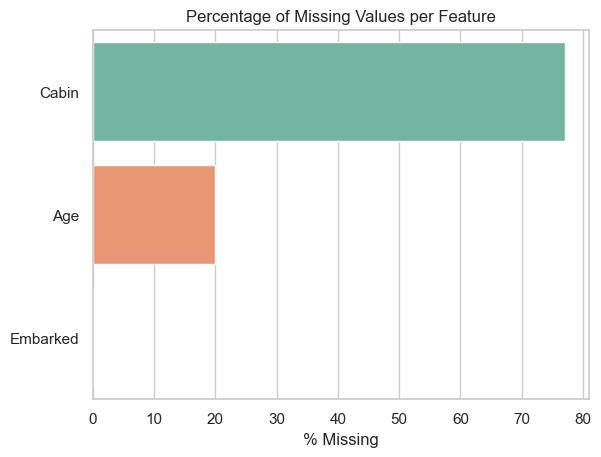

👉 This chart highlights which columns have missing data and how much. It helps us decide which variables need imputation (like 'Age' and 'Cabin').


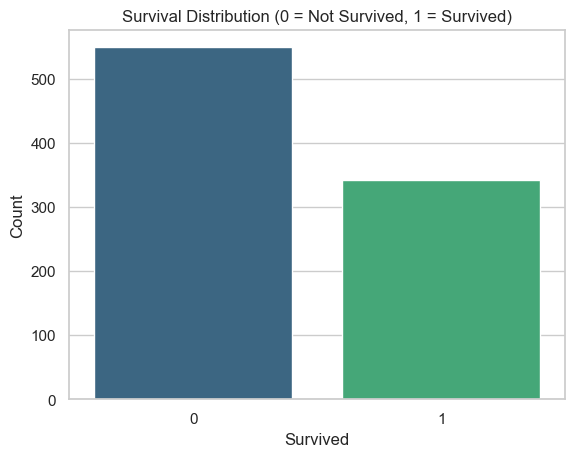

👉 This plot shows the overall class imbalance: how many passengers survived versus did not survive.


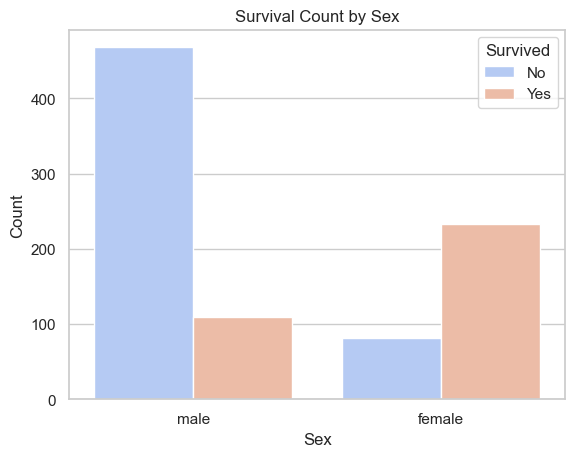

👉 Female passengers had a much higher survival rate than males, confirming the 'women and children first' evacuation pattern.


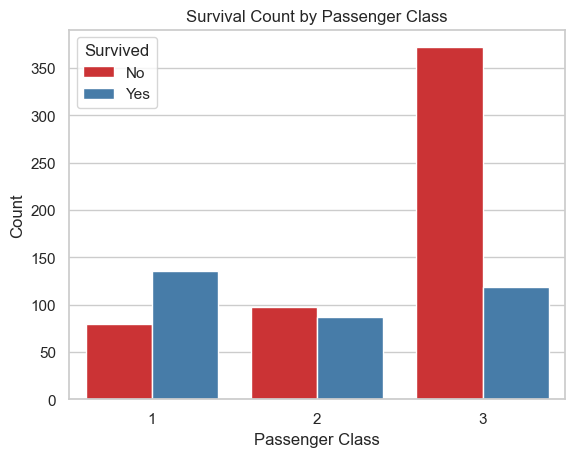

👉 Higher-class passengers (1st class) had significantly better survival chances than those in lower classes (3rd class).


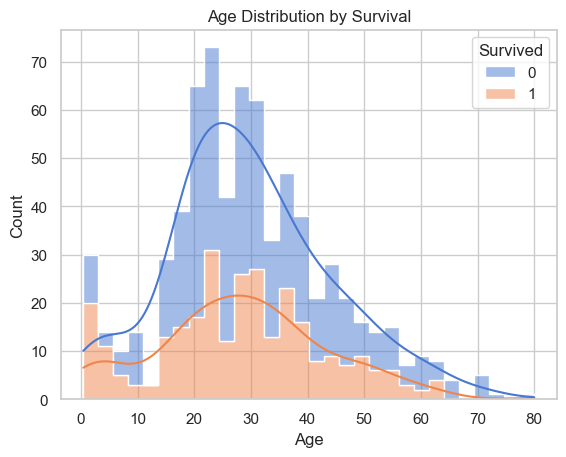

👉 Younger passengers and children appear to have a slightly higher chance of survival. This supports the 'women and children first' pattern.


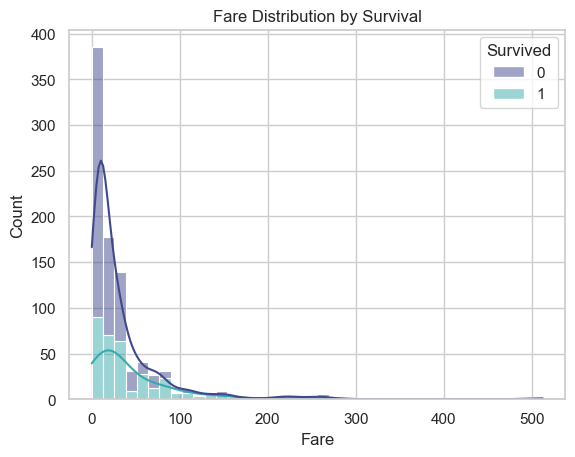

👉 Passengers who paid higher fares were more likely to survive, which correlates with being in higher classes.


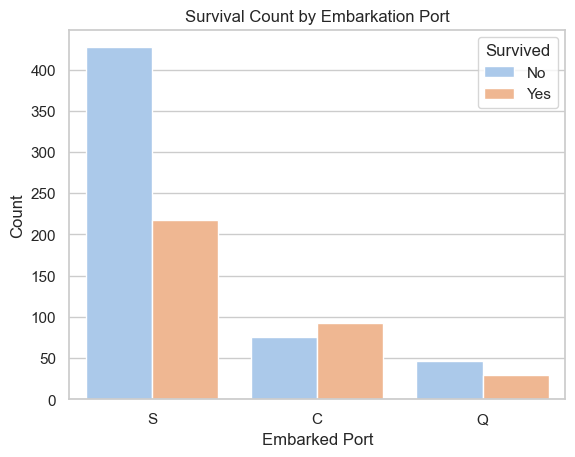

👉 Passengers who embarked from port 'C' seem to have higher survival rates, possibly due to socio-economic differences.


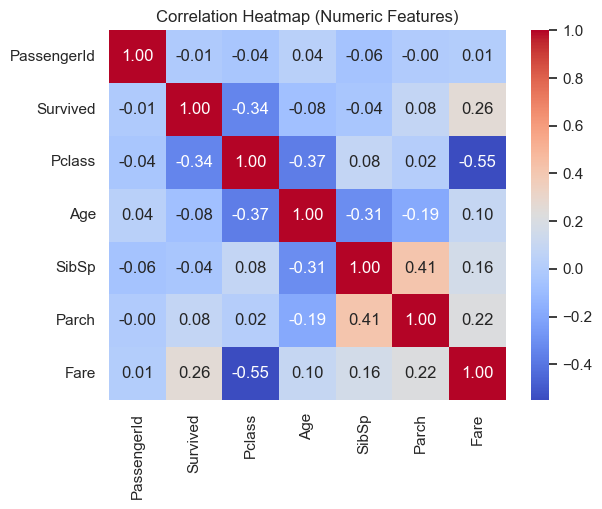

👉 This heatmap shows numerical relationships. For example, 'Fare' and 'Pclass' are negatively correlated, while 'Sex' (encoded later) will strongly correlate with survival.


In [11]:
# Your EDA code here. 
# Examples: 
# - train_df.info()
# - train_df.describe()
# - sns.countplot(x='Survived', data=train_df)
# - sns.catplot(x='Sex', col='Survived', kind='count', data=train_df)

# ============================================================
# 2) Exploratory Data Analysis (EDA) — Seaborn Only
# ============================================================

sns.set(style="whitegrid", palette="Set2")

# ------------------------------------------------------------
# 1) Missing Values
# ------------------------------------------------------------
missing = train_df.isnull().mean().sort_values(ascending=False) * 100
missing = missing[missing > 0].reset_index()
missing.columns = ["Feature", "Missing (%)"]

sns.barplot(data=missing, x="Missing (%)", y="Feature", hue="Feature", dodge=False, legend=False)
plt.title("Percentage of Missing Values per Feature")
plt.xlabel("% Missing")
plt.ylabel("")
plt.show()

print("👉 This chart highlights which columns have missing data and how much. "
      "It helps us decide which variables need imputation (like 'Age' and 'Cabin').")

# ------------------------------------------------------------
# 2) Survival Distribution
# ------------------------------------------------------------
sns.countplot(data=train_df, x="Survived", hue="Survived", palette="viridis", legend=False)
plt.title("Survival Distribution (0 = Not Survived, 1 = Survived)")
plt.xlabel("Survived")
plt.ylabel("Count")
plt.show()

print("👉 This plot shows the overall class imbalance: "
      "how many passengers survived versus did not survive.")

# ------------------------------------------------------------
# 3) Survival by Sex
# ------------------------------------------------------------
sns.countplot(data=train_df, x="Sex", hue="Survived", palette="coolwarm")
plt.title("Survival Count by Sex")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])
plt.show()

print("👉 Female passengers had a much higher survival rate than males, "
      "confirming the 'women and children first' evacuation pattern.")

# ------------------------------------------------------------
# 4) Survival by Passenger Class
# ------------------------------------------------------------
sns.countplot(data=train_df, x="Pclass", hue="Survived", palette="Set1")
plt.title("Survival Count by Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])
plt.show()

print("👉 Higher-class passengers (1st class) had significantly better survival chances "
      "than those in lower classes (3rd class).")

# ------------------------------------------------------------
# 5) Age Distribution vs Survival
# ------------------------------------------------------------
sns.histplot(
    data=train_df, x="Age", hue="Survived", bins=30, kde=True,
    palette="muted", element="step", multiple="stack"
)
plt.title("Age Distribution by Survival")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

print("👉 Younger passengers and children appear to have a slightly higher chance of survival. "
      "This supports the 'women and children first' pattern.")

# ------------------------------------------------------------
# 6) Fare Distribution vs Survival
# ------------------------------------------------------------
sns.histplot(
    data=train_df, x="Fare", hue="Survived", bins=40, kde=True,
    palette="mako", multiple="stack"
)
plt.title("Fare Distribution by Survival")
plt.xlabel("Fare")
plt.ylabel("Count")
plt.show()

print("👉 Passengers who paid higher fares were more likely to survive, "
      "which correlates with being in higher classes.")

# ------------------------------------------------------------
# 7) Survival by Embarkation Port
# ------------------------------------------------------------
sns.countplot(data=train_df, x="Embarked", hue="Survived", palette="pastel")
plt.title("Survival Count by Embarkation Port")
plt.xlabel("Embarked Port")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])
plt.show()

print("👉 Passengers who embarked from port 'C' seem to have higher survival rates, "
      "possibly due to socio-economic differences.")

# ------------------------------------------------------------
# 8) Correlation Heatmap
# ------------------------------------------------------------
corr = train_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

print("👉 This heatmap shows numerical relationships. "
      "For example, 'Fare' and 'Pclass' are negatively correlated, "
      "while 'Sex' (encoded later) will strongly correlate with survival.")



## 3. Data Cleaning & Feature Engineering

Based on our EDA, we'll clean the data by handling missing values and create new features to improve our model's performance.

In [54]:
# ============================================================
# 3. Data Cleaning & Feature Engineering
# ============================================================

# --- 3.1: Imputation Age par médiane (groupes Pclass x Sex) ---
def age_fill(df: pd.DataFrame) -> None:
    df.loc[:, 'Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
    df.loc[:, 'Age'] = df['Age'].fillna(df['Age'].median())

age_fill(train_df)
age_fill(test_df)

# --- 3.2: Cabin -> indicateur binaire Has_Cabin puis drop ---
for ds in (train_df, test_df):
    ds.loc[:, 'Has_Cabin'] = ds['Cabin'].notna().astype(int)
    ds.drop(columns=['Cabin'], inplace=True)

# --- 3.3: Embarked -> remplir au mode ---
for ds in (train_df, test_df):
    ds.loc[:, 'Embarked'] = ds['Embarked'].fillna(ds['Embarked'].mode()[0])

# --- 3.4: Title depuis Name (+ regrouper titres rares) ---
def create_features(df: pd.DataFrame) -> None:
    df.loc[:, 'Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
    title_mapping = {
        'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
        'Major': 'Rare', 'Col': 'Rare', 'Sir': 'Rare',
        'Don': 'Rare', 'Lady': 'Rare', 'Countess': 'Rare',
        'Jonkheer': 'Rare', 'Dona': 'Rare', 'Capt': 'Rare',
        'Rev': 'Rare', 'Dr': 'Rare'
    }
    df.loc[:, 'Title'] = df['Title'].replace(title_mapping)

create_features(train_df)
create_features(test_df)

# Harmoniser les titres très rares entre train et test
def title_match(df: pd.DataFrame) -> None:
    counts = df['Title'].value_counts()
    rare = counts[counts < 10].index
    mask = df['Title'].isin(rare)
    df.loc[mask, 'Title'] = df.loc[mask, 'Sex'].map({'male': 'Mr', 'female': 'Mrs'})

title_match(train_df)
title_match(test_df)

# --- 3.5: Autres features utiles ---
def create_more_features(df: pd.DataFrame) -> None:
    df.loc[:, 'FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df.loc[:, 'IsAlone']    = (df['FamilySize'] == 1).astype(int)

    # Interactions
    df.loc[:, 'Fare']     = df['Fare'].fillna(df['Fare'].median())
    df.loc[:, 'Age*Class'] = df['Age'] * df['Pclass']
    df.loc[:, 'Age*Fare']  = df['Age'] * df['Fare']

    # Groupes d'âge (catégories ordonnées)
    df.loc[:, 'AgeGroup'] = pd.cut(
        df['Age'],
        bins=[0, 12, 18, 35, 60, 100],
        labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'],
        include_lowest=True
    ).astype(object)

    # Quartiles de tarif (entier 0..3)
    df.loc[:, 'FareBand'] = pd.qcut(df['Fare'], q=4, labels=[0, 1, 2, 3]).astype(int)

    # Log-transform du tarif
    df.loc[:, 'Fare_log'] = np.log1p(df['Fare'])

create_more_features(train_df)
create_more_features(test_df)

# --- 3.6: Sélection des colonnes d'entrée (comme dans ton code) ---
input_cols = [
    'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Has_Cabin',
    'FamilySize', 'IsAlone', 'Age*Class', 'Age*Fare', 'AgeGroup',
    'FareBand', 'Fare_log'
]
target_col = 'Survived'

# Découpage Train/Validation
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs   = val_df[input_cols].copy()
val_targets  = val_df[target_col].copy()

test_inputs  = test_df[input_cols].copy()

# --- 3.7: Colonnes numériques vs catégorielles ---
numeric_cols = [c for c in train_inputs.columns if train_inputs[c].dtype != 'O']
categorical_cols = [c for c in train_inputs.columns if train_inputs[c].dtype == 'O']

# --- 3.8: Scaling des numériques ---
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(train_inputs[numeric_cols])

train_inputs.loc[:, numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs.loc[:, numeric_cols]   = scaler.transform(val_inputs[numeric_cols])
test_inputs.loc[:, numeric_cols]  = scaler.transform(test_inputs[numeric_cols])

# --- 3.9: One-hot des catégorielles (robuste aux versions de sklearn) ---
from sklearn.preprocessing import OneHotEncoder

try:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(train_inputs[categorical_cols])
except TypeError:
    # fallback pour versions plus anciennes de scikit-learn
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(train_inputs[categorical_cols])

encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

train_cat = encoder.transform(train_inputs[categorical_cols])
val_cat   = encoder.transform(val_inputs[categorical_cols])
test_cat  = encoder.transform(test_inputs[categorical_cols])

train_cat_df = pd.DataFrame(train_cat, index=train_inputs.index, columns=encoded_cols)
val_cat_df   = pd.DataFrame(val_cat,   index=val_inputs.index,   columns=encoded_cols)
test_cat_df  = pd.DataFrame(test_cat,  index=test_inputs.index,  columns=encoded_cols)

# Concaténer numériques + encodées
X_train = pd.concat([train_inputs[numeric_cols], train_cat_df], axis=1)
X_val   = pd.concat([val_inputs[numeric_cols],   val_cat_df],   axis=1)
X_test  = pd.concat([test_inputs[numeric_cols],  test_cat_df],  axis=1)

# Petites sécurités : imputations finales si besoin
X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(X_train.median(numeric_only=True))
X_val   = X_val.apply(pd.to_numeric, errors='coerce').fillna(X_val.median(numeric_only=True))
X_test  = X_test.apply(pd.to_numeric, errors='coerce').fillna(X_test.median(numeric_only=True))

# Cibles sûres
y_train = pd.to_numeric(train_targets, errors='coerce')
y_val   = pd.to_numeric(val_targets,   errors='coerce')

print("X_train:", X_train.shape, "| X_val:", X_val.shape, "| X_test:", X_test.shape)
print("Numeric cols:", len(numeric_cols), "| Encoded cols:", len(encoded_cols))

X_train: (712, 19) | X_val: (179, 19) | X_test: (418, 19)
Numeric cols: 12 | Encoded cols: 7


C:\Users\tcper\AppData\Local\Temp\ipykernel_4384\3717967962.py:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.61413602 -0.40055118  0.81303367  0.81303367  0.81303367 -1.61413602
 -1.61413602 -0.40055118  0.81303367 -1.61413602 -0.40055118  0.81303367
 -0.40055118  0.81303367  0.81303367 -0.40055118 -1.61413602 -1.61413602
 -0.40055118 -1.61413602  0.81303367  0.81303367  0.81303367 -0.40055118
  0.81303367  0.81303367  0.81303367  0.81303367 -1.61413602  0.81303367
  0.81303367 -1.61413602  0.81303367 -1.61413602  0.81303367  0.81303367
  0.81303367 -0.40055118 -1.61413602 -0.40055118  0.81303367  0.81303367
 -0.40055118  0.81303367 -1.61413602  0.81303367 -0.40055118  0.81303367
 -1.61413602 -0.40055118  0.81303367 -0.40055118 -1.61413602  0.81303367
  0.81303367  0.81303367  0.81303367 -1.61413602  0.81303367 -1.61413602
 -0.40055118  0.81303367 -0.40055118  0.81303367  0.81303367  0.81303367
  0.8130336

## 4. Model Training and Evaluation

It's time to choose a model, train it on our processed data, and see how well it performs.

In [55]:
# ============================================================
# 4. Model Training and Evaluation
# ============================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Modèle de base
rf = RandomForestClassifier(random_state=42, n_jobs=-1, bootstrap=True)

# Espace de recherche (raisonnable pour Kaggle)
param_dist = {
    'n_estimators':     [200, 300, 500],
    'max_depth':        [12, 14, 16, None],
    'min_samples_split':[5, 10, 15, 20],
    'min_samples_leaf': [2, 4, 6, 8],
    'max_features':     [0.5, 'sqrt', 0.7],
    'max_samples':      [0.6, 0.7, 0.8, 0.9]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=40,
    scoring='accuracy',       # tu peux mettre 'f1' si tu préfères
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit sur le train
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best CV Score: ", random_search.best_score_)

best_model = random_search.best_estimator_

# Évaluation hold-out (validation)
val_pred      = best_model.predict(X_val)
val_pred_proba= best_model.predict_proba(X_val)[:, 1]

print("\n=== VALIDATION METRICS ===")
print(f"Accuracy : {accuracy_score(y_val, val_pred):.4f}")
print(f"Precision: {precision_score(y_val, val_pred):.4f}")
print(f"Recall   : {recall_score(y_val, val_pred):.4f}")
print(f"F1-Score : {f1_score(y_val, val_pred):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_val, val_pred_proba):.4f}")

# Cross-validation (en plus, sur le train)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(best_model, X_train, y_train, cv=cv, scoring='accuracy', return_train_score=True)
print("\n=== CROSS-VALIDATION (train only) ===")
print(f"Train CV mean: {cv_results['train_score'].mean():.4f}")
print(f"Val   CV mean: {cv_results['test_score'].mean():.4f}")

# Entraînement final sur train complet (pour usage ultérieur sur X_test)
best_model.fit(X_train, y_train)

# (Option) prédiction sur X_test si besoin plus tard :
# test_pred = best_model.predict(X_test)
# submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': test_pred})
# submission.to_csv('submission.csv', index=False)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_samples': 0.8, 'max_features': 0.5, 'max_depth': 14}
Best CV Score:  0.8426671919629666

=== VALIDATION METRICS ===
Accuracy : 0.8324
Precision: 0.8548
Recall   : 0.7162
F1-Score : 0.7794
ROC-AUC  : 0.8945

=== CROSS-VALIDATION (train only) ===
Train CV mean: 0.8708
Val   CV mean: 0.8202


RandomForestClassifier(max_depth=14, max_features=0.5, max_samples=0.8,
                       min_samples_leaf=6, min_samples_split=10,
                       n_estimators=300, n_jobs=-1, random_state=42)

## 5. Create Submission File

Finally, we'll use our trained model to make predictions on the test set and generate the submission file in the required format.

In [56]:
# ============================================================
# 5. Create Submission File
# ============================================================

# Prédictions sur le jeu de test
test_pred = best_model.predict(X_test)

# Par sécurité, forcer en int (0/1)
test_pred = pd.Series(test_pred).astype(int).values

# Construire le DataFrame de soumission
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'].values,
    'Survived': test_pred
})

# Sauvegarde
out_path = 'submission.csv'
submission.to_csv(out_path, index=False)

print("Aperçu de la soumission :")
print(submission.head())
print(f"\nFichier écrit : {out_path} | Shape: {submission.shape}")

Aperçu de la soumission :
   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         0

Fichier écrit : submission.csv | Shape: (418, 2)
